In [65]:
from matplotlib import pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, MaxPooling1D, UpSampling1D, LSTM ,Dropout, Embedding
from keras.layers.convolutional import Conv1D, Conv2D
import medleydb as mdb
from scipy import signal
from scipy.io import wavfile
import pandas as pd

In [66]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

# Load the audio data

In [67]:
multitracks = mdb.load_multitracks([
    "Phoenix_ColliersDaughter", 
    "Phoenix_BrokenPledgeChicagoReel", 
    "Phoenix_ElzicsFarewell", 
    "Phoenix_LarkOnTheStrandDrummondCastle",
    "Phoenix_ScotchMorris",
    "Phoenix_SeanCaughlinsTheScartaglen"
])

In [68]:
mix_audio = None
instrument_audio = None

for mix in multitracks:
    sample_rate, song = wavfile.read(mix.mix_path)
    
    if mix_audio is None:
        mix_audio = song
    
    else:
        mix_audio = np.concatenate((mix_audio, song))
    
    #
    
    instruments = mdb.get_files_for_instrument("violin", [mix])

    instrument = next(instruments)
    
    sample_rate, track = wavfile.read(instrument)
    
    if instrument_audio is None:
        instrument_audio = track
    
    else:
        instrument_audio = np.concatenate((instrument_audio, track))
    
mix_audio = mix_audio.mean(1)
instrument_audio = instrument_audio.mean(1)

In [69]:
samples_per_period = 256
overlap = int(samples_per_period/2)

# Process the Mix

In [70]:
freqs, times, s_mix = signal.stft(mix_audio, fs=sample_rate, nfft=samples_per_period, 
                                         noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_mix = s_mix[:-1,:]

In [71]:
#plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_mix)))
#plt.title("STFT of the Mix")
#plt.ylabel("Frequency (Hz)")
#plt.xlabel("Time (s)")

# Process the Target Instrument

In [72]:
freqs, times, s_instrument = signal.stft(instrument_audio, fs=sample_rate, nfft=samples_per_period, 
                                               noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_instrument = s_instrument[:-1,:]
s_instrument += 1e-9

In [73]:
#plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_instrument)))
#plt.title("STFT of the instrument Track")
#plt.xlabel("Time (s)")
#plt.ylabel("Frequency (Hz)")

# Prepare the training data

In [74]:
num_test  = int((sample_rate * 120)/samples_per_period)
num_train = s_mix.shape[1] - num_test
print(num_train, num_test)

374742 20671


In [75]:
mix_train = s_mix.T[:num_train,:,np.newaxis]
mix_train = np.concatenate((mix_train.real, mix_train.imag), axis=-1)
mix_train.shape

(374742, 128, 2)

In [76]:
instrument_train = s_instrument.T[:num_train,:,np.newaxis]
instrument_train = np.concatenate((instrument_train.real, instrument_train.imag), axis=-1)
instrument_train.shape

(374742, 128, 2)

In [77]:
mix_test = s_mix.T[-num_test:,:,np.newaxis]
mix_test = np.concatenate((mix_test.real, mix_test.imag), axis=-1)
mix_test.shape

(20671, 128, 2)

In [78]:
instrument_test = s_instrument.T[-num_test:,:,np.newaxis]
instrument_test = np.concatenate((instrument_test.real, instrument_test.imag), axis=-1)
instrument_test.shape

(20671, 128, 2)

In [79]:
max_features=2000
embedding_size=128
maxlen=100

In [125]:
model = Sequential()

model.add(Conv1D(16, 2, padding="same", input_shape=mix_train.shape[1:], activation="relu", name="Conv1D_1"))
model.add(MaxPooling1D(2, padding="same", name="MaxPooling_1"))

model.add(Conv1D(16, 2, padding="same",  activation="relu", name="Conv1D_2"))
model.add(MaxPooling1D(2, padding="same", name="MaxPooling_2"))


model.add(LSTM(units =10, return_sequences=True)) 
model.add(Dropout(0.4))

model.add(LSTM(units =10, return_sequences=True)) 
model.add(Dropout(0.4))

model.add(Conv1D(16, 2, padding="same",  activation="relu", name="Conv1D_5"))
model.add(UpSampling1D(2, name="UpSampling_2"))

model.add(Conv1D(16, 2, padding="same",  activation="relu", name="Conv1D_6"))
model.add(UpSampling1D(2, name="UpSampling_3"))

model.add(Conv1D(2, 2, padding="same",  name="Conv1D_7"))


model.add(Dense(units=2))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 128, 10)           520       
_________________________________________________________________
dropout_12 (Dropout)         (None, 128, 10)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 128, 10)           840       
_________________________________________________________________
dropout_13 (Dropout)         (None, 128, 10)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 128, 10)           840       
_________________________________________________________________
dropout_14 (Dropout)         (None, 128, 10)           0         
_________________________________________________________________
dense_10 (Dense)             (None, 128, 2)            22        
Total para

In [126]:
model.compile('adam', loss='mean_absolute_error', metrics=['accuracy'])

In [127]:
history = model.fit(mix_train, instrument_train, batch_size=200, epochs=2)

Epoch 1/2
374742/374742 [==============================] - 272s 727us/step - loss: 12.4725 - acc: 0.5014
Epoch 2/2
374742/374742 [==============================] - 273s 729us/step - loss: 12.3199 - acc: 0.5006


In [128]:
results = model.evaluate(mix_test, instrument_test)

print(model.metrics_names)
print(results)

20671/20671 [==============================] - 15s 736us/step
['loss', 'acc']
[15.256614904730696, 0.5011587791917264]


# Results

In [129]:
prediction = model.predict(mix_test)
prediction.shape

(20671, 128, 2)

In [130]:
prediction = (prediction[:,:,0]+prediction[:,:,1] * 1j).T
prediction += 1e-9

In [131]:
#prediction = (prediction[:,0]+prediction[:,1] * 2j)
#prediction += 1e-9
#prediction.shape

In [132]:
target = s_instrument[:, -num_test:]

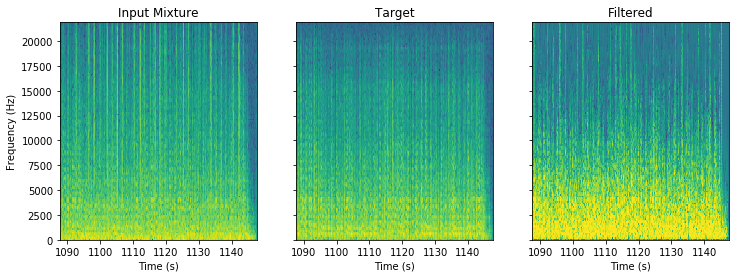

In [133]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True,figsize=(12, 4))

ax1.set_title("Input Mixture")
ax2.set_title("Target")
ax3.set_title("Filtered")

ax1.set_ylabel("Frequency (Hz)")
ax1.set_xlabel("Time (s)")
ax2.set_xlabel("Time (s)")
ax3.set_xlabel("Time (s)")

ax1.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(s_mix[:,-num_test:])))
ax2.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(target)))
ax3.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(prediction)))

## Let's hear it

In [134]:
_, predicted_audio = signal.istft(prediction, fs=sample_rate)
_, target_audio = signal.istft(target, fs=sample_rate)
_, mix_audio = signal.istft(s_mix[:,-num_test:], fs=sample_rate)

wavfile.write("dense_lstm_dense_prediction.wav", sample_rate, predicted_audio.astype(np.int16))
wavfile.write("dense_lstm_dense_target.wav", sample_rate, target_audio.astype(np.int16))
wavfile.write("original.wav", sample_rate, mix_audio.astype(np.int16))